In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from pathlib import Path
from superRes.metrics import *
from superRes.ssim import *
from superRes.fid_loss import *
from superRes.save import *
from superRes.loss import *
from superRes.dataset import *
from superRes.critics import *
from superRes.generators import *
from fastai.vision import *
from fastai import *

from datetime import datetime
import geffnet  # efficient/ mobile net

In [3]:
def get_DIV2k_data_patches(pLow, bs: int):
    """Given the path of low resolution images with a proper suffix
       returns a databunch
    """
    src = ImageImageList.from_folder(pLow, presort=True).split_by_idxs(
        train_idx=list(range(0, 565407)), valid_idx=list(range(565408, 637408)))
    data = (src.label_from_func(lambda x: path_fullRes_patches/x.name)
            .databunch(bs=bs, num_workers=8, no_check=True).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data

In [4]:
def do_fit(learn, epochs, save_name, lrs=slice(1e-3), pct_start=0.3):
    learn.fit_one_cycle(epochs, lrs, pct_start=pct_start)
    learn.save("/data/students_home/fmameli/repos/SuperRes/models/" + save_name)
    learn.show_results(rows=1, imgsize=5)

In [5]:
path = Path('./dataset/')

path_fullRes_patches = path/"DIV2K_train_HR_Patches"/"64px_FullQF20"
path_lowRes_patches = path/"DIV2K_train_LR_Patches"/"64px_FullQF20"

path_fullRes = path/'DIV2K_train_HR'
path_lowRes_256 = path/'DIV2K_train_LR_256_QF20'
path_lowRes_512 = path/'DIV2K_train_LR_512_QF20'
path_lowRes_Full = path/'DIV2K_train_LR_Full_QF20'

proj_id = 'unet_wideNf2_superRes_mobilenetV3_P64px_Alex'

gen_name = proj_id + '_gen'
crit_name = proj_id + '_crit'

In [6]:
print(path_fullRes_patches)
print(path_lowRes_patches)

dataset/DIV2K_train_HR_Patches/64px_FullQF20
dataset/DIV2K_train_LR_Patches/64px_FullQF20


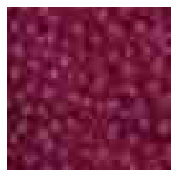

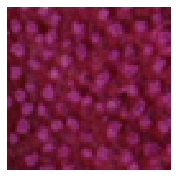

In [14]:
lr = ImageList.from_folder(path_lowRes_patches, presort=True)
hr = ImageList.from_folder(path_fullRes_patches, presort=True)

lr[42].show()
hr[42].show()

In [6]:
model = geffnet.mobilenetv3_rw
# model = models.resnet34
# model= geffnet.efficientnet_b4

In [7]:
loss_func = lpips_loss()

Setting up Perceptual loss...
Loading model from: /data/students_home/fmameli/anaconda3/envs/fastai/lib/python3.6/site-packages/perceptual_similarity/weights/v0.1/alex.pth
...[net-lin [alex]] initialized
...Done


# 64px patch

In [22]:
bs=128
sz=64
lr = 1e-3
wd = 1e-3
epochs = 1

In [23]:
data_gen = get_DIV2k_data_patches(path_lowRes_patches, bs=bs)

In [27]:
learn_gen = gen_learner_wide(data=data_gen,
                             gen_loss=loss_func,
                             arch = model,
                             nf_factor=2)

In [40]:
learn_gen.metrics.append(SSIM_Metric_gen())
learn_gen.metrics.append(SSIM_Metric_input())

In [ ]:
wandbCallbacks = False

if wandbCallbacks:
    import wandb
    from wandb.fastai import WandbCallback
    config={"batch_size": bs,
            "img_size": (sz, sz),
            "learning_rate": lr,
            "weight_decay": wd,
            "num_epochs": epochs
    }
    wandb.init(project='SuperRes', config=config, id="unet_superRes_mobilenetV3_Patches64px"+ datetime.now().strftime('_%m-%d_%H:%M'))

    learn_gen.callback_fns.append(partial(WandbCallback, input_type='images'))

In [28]:
learn_gen.summary()

DynamicUnetWide
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 32, 32]         432        False     
______________________________________________________________________
BatchNorm2d          [16, 32, 32]         32         True      
______________________________________________________________________
HardSwish            [16, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [16, 32, 32]         144        False     
______________________________________________________________________
BatchNorm2d          [16, 32, 32]         32         True      
______________________________________________________________________
ReLU                 [16, 32, 32]         0          False     
______________________________________________________________________
Identity             [16, 32, 32]         0          False     
______________________________________________

In [ ]:
do_fit(learn_gen, 1, gen_name+"_64px_0", 1e-3)

In [ ]:
learn_gen.unfreeze()

In [ ]:
do_fit(learn_gen, 3, gen_name+"_64px_1", 1e-3)

# Validate

In [15]:
bs=2
sz=512
epochs = 1

In [16]:
data_gen = get_DIV2k_data_QF(path_lowRes_512, path_fullRes, bs=bs, sz=sz)

In [9]:
path_lowRes_512

PosixPath('dataset/DIV2K_train_LR_512_QF20')

In [17]:
learn_gen.data = data_gen

In [11]:
learn_gen = gen_learner_wide(data=data_gen,
                             gen_loss=loss_func,
                             arch = model,
                             nf_factor=2)

In [12]:
learn_gen.metrics.append(SSIM_Metric_gen())
learn_gen.metrics.append(SSIM_Metric_input())
learn_gen.metrics.append(LPIPS_Metric_gen())
learn_gen.metrics.append(LPIPS_Metric_input())
learn_gen.metrics.append(BRISQUE_Metric_gen())
learn_gen.metrics.append(BRISQUE_Metric_input())
learn_gen.metrics.append(BRISQUE_Metric_target())
learn_gen.metrics.append(NIQE_Metric_gen())
learn_gen.metrics.append(NIQE_Metric_input())
learn_gen.metrics.append(NIQE_Metric_target())

Setting up Perceptual loss...
Loading model from: /data/students_home/fmameli/anaconda3/envs/fastai/lib/python3.6/site-packages/perceptual_similarity/weights/v0.1/alex.pth
...[net-lin [alex]] initialized
...Done
Setting up Perceptual loss...
Loading model from: /data/students_home/fmameli/anaconda3/envs/fastai/lib/python3.6/site-packages/perceptual_similarity/weights/v0.1/alex.pth
...[net-lin [alex]] initialized
...Done


In [31]:
learn_gen.load("/data/students_home/fmameli/repos/SuperRes/models/unet_wideNf2_superRes_mobilenetV3_P64px_Alex_Best")

Learner(data=ImageDataBunch;

Train: LabelList (800 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: dataset/DIV2K_train_LR_512_QF20;

Valid: LabelList (100 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: dataset/DIV2K_train_LR_512_QF20;

Test: None, model=DynamicUnetWide(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): HardSwish()
      (3): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
 

In [32]:
val = learn_gen.validate()

In [33]:
for name, m in zip(learn_gen.metrics, val[1:]):
    if isinstance(m, torch.Tensor):
        print(name, m.item())
    else:
        print(name, m)

SSIM_Metric_gen 0.7370271682739258
SSIM_Metric_input 0.7075173854827881
LPIPS_Metric_gen 0.15983138978481293
LPIPS_Metric_input 0.1764998435974121
BRISQUE_Metric_gen 91.69969570943333
BRISQUE_Metric_input 87.3549426119021
BRISQUE_Metric_target 85.32215693738695
NIQE_Metric_gen 18.472084
NIQE_Metric_input 17.860744
NIQE_Metric_target 15.693551


In [14]:
for name, m in zip(learn_gen.metrics, val[1:]):
    if isinstance(m, torch.Tensor):
        print(name, m.item())
    else:
        print(name, m)

SSIM_Metric_gen 0.7443229556083679
SSIM_Metric_input 0.7075174450874329
LPIPS_Metric_gen 0.17269474267959595
LPIPS_Metric_input 0.1764998584985733
BRISQUE_Metric_gen 89.95976401728049
BRISQUE_Metric_input 87.3549426119021
BRISQUE_Metric_target 85.32215693738695
NIQE_Metric_gen 17.90524
NIQE_Metric_input 17.860744
NIQE_Metric_target 15.693551


# Test

In [19]:
bs=1
sz=512
epochs = 1

In [20]:
path_lowRes_512 = path/'DIV2K_train_LR_512_QF35'
size=( 512, 680)

In [21]:
data_1k = (ImageImageList.from_folder(path_lowRes_512, presort=True).split_by_idxs(
            train_idx=list(range(0, 800)), valid_idx=list(range(800, 900)))
          .label_from_func(lambda x: path_fullRes/x.name.replace(".jpg", ".png"))
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_1k.c = 3

In [22]:
learn_gen = gen_learner_wide(data=data_1k,
                             gen_loss=lpips_loss(),
                             arch = geffnet.mobilenetv3_rw,
                             nf_factor=nf_factor)

Setting up Perceptual loss...
Loading model from: /data/students_home/fmameli/anaconda3/envs/fastai/lib/python3.6/site-packages/perceptual_similarity/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done


In [23]:
learn_gen.load("/data/students_home/fmameli/repos/SuperRes/models/unet_wideNf2_superRes_mobilenetV3_Patches64px_gen_64px_0")

Learner(data=ImageDataBunch;

Train: LabelList (800 items)
x: ImageImageList
Image (3, 512, 680),Image (3, 512, 680),Image (3, 512, 680),Image (3, 512, 680),Image (3, 512, 680)
y: ImageList
Image (3, 512, 680),Image (3, 512, 680),Image (3, 512, 680),Image (3, 512, 680),Image (3, 512, 680)
Path: dataset/DIV2K_train_LR_512_QF35;

Valid: LabelList (100 items)
x: ImageImageList
Image (3, 512, 680),Image (3, 512, 680),Image (3, 512, 680),Image (3, 512, 680),Image (3, 512, 680)
y: ImageList
Image (3, 512, 680),Image (3, 512, 680),Image (3, 512, 680),Image (3, 512, 680),Image (3, 512, 680)
Path: dataset/DIV2K_train_LR_512_QF35;

Test: None, model=DynamicUnetWide(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): HardSwish()
      (3): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
 

In [24]:
gc.collect()

140

In [25]:
fn = data_1k.valid_dl.x.items[2]; fn

PosixPath('dataset/DIV2K_train_LR_512_QF35/0803.jpg')

In [26]:
fnFull = data_1k.valid_dl.y.items[2]; fnFull

PosixPath('dataset/DIV2K_train_HR/0803.png')

In [27]:
img = open_image(fn); print(img.shape)
p,img_hr,b = learn_gen.predict(img)

torch.Size([3, 512, 680])


In [29]:
p.size

torch.Size([512, 680])

In [34]:
p.save('output_imgs/flower_512_patches64px.png')

In [13]:
help(p)

Help on Image in module fastai.vision.image object:

class Image(fastai.core.ItemBase)
 |  Support applying transforms to image data in `px`.
 |  
 |  Method resolution order:
 |      Image
 |      fastai.core.ItemBase
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, px:torch.Tensor)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  affine(self, func:Callable[[Dict[str, Any]], torch.Tensor], *args, **kwargs) -> 'Image'
 |      Equivalent to `image.affine_mat = image.affine_mat @ func()`.
 |  
 |  apply_tfms(self, tfms:Union[Callable, Collection[Callable]], do_resolve:bool=True, xtra:Union[Dict[Callable, dict], NoneType]=None, size:Union[int, Tuple[int, int, int], NoneType]=None, resize_method:fastai.vision.image.ResizeMethod=None, mult:int=None, padding_mode:str='reflection', mode:str='bilinear', remove_out:bool=True) -> torch.Tensor
 |      Apply all `tfms` to the `Image`, if

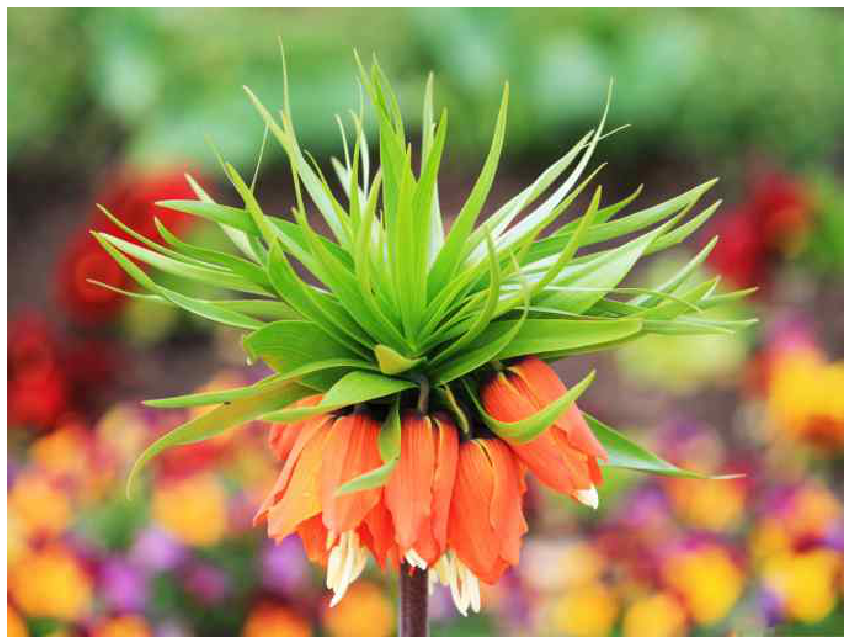

In [36]:
show_image(img, figsize=(15,15), interpolation='nearest');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


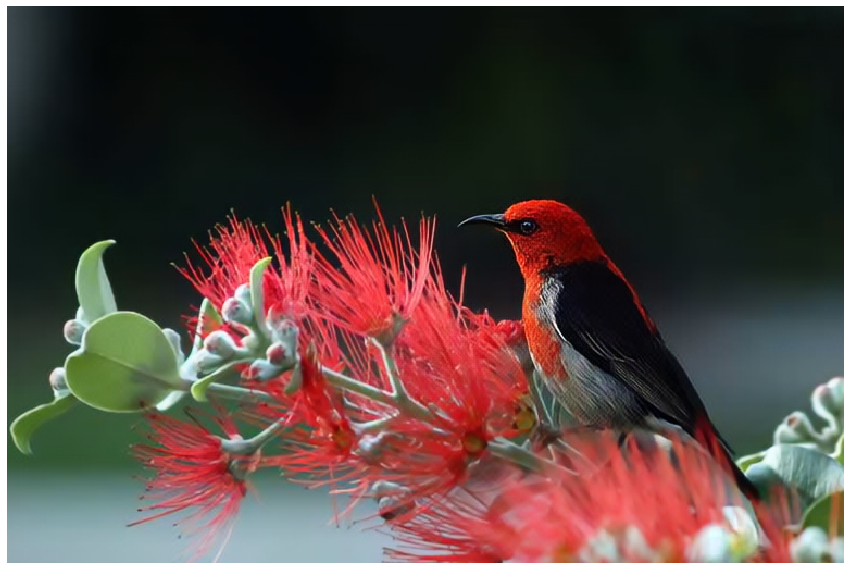

In [87]:
Image(img_hr).show(figsize=(15,15))

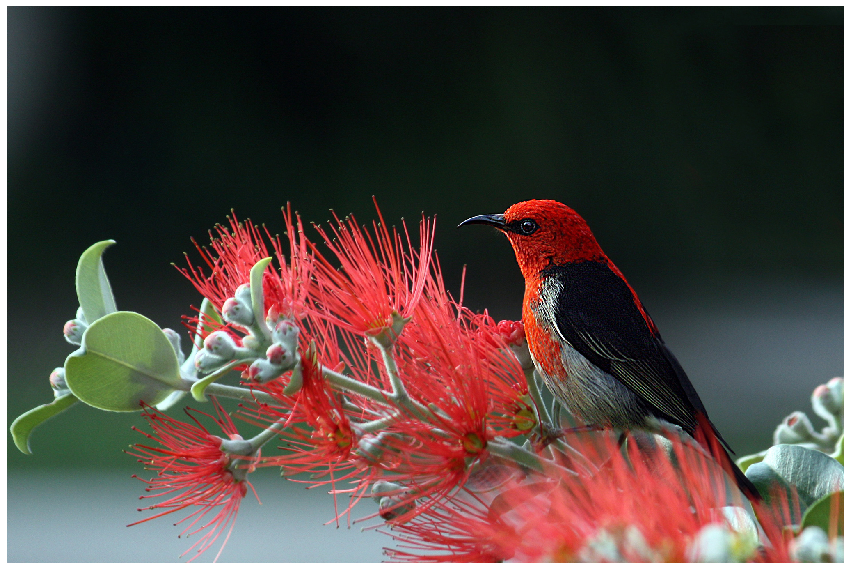

In [88]:
img = open_image(fnFull);
show_image(img, figsize=(15,15), interpolation='nearest');

# Test deep unet 64px

In [3]:
bs=1
sz=512
epochs = 1

In [4]:
path_lowRes_512 = path/'DIV2K_train_LR_512_QF35'
size=( 512, 770)

In [5]:
data_1k = (ImageImageList.from_folder(path_lowRes_512, presort=True).split_by_idxs(
            train_idx=list(range(0, 800)), valid_idx=list(range(800, 900)))
          .label_from_func(lambda x: path_fullRes/x.name.replace(".jpg", ".png"))
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_1k.c = 3

In [6]:
model = geffnet.mobilenetv3_rw

loss_func = lpips_loss()

Setting up Perceptual loss...
Loading model from: /data/students_home/fmameli/anaconda3/envs/fastai/lib/python3.6/site-packages/perceptual_similarity/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done


In [7]:
learn_gen = gen_learner_deep(data=data_1k,
                             gen_loss=lpips_loss(),
                             arch = geffnet.mobilenetv3_rw,
                             nf_factor=nf_factor)

Setting up Perceptual loss...
Loading model from: /data/students_home/fmameli/anaconda3/envs/fastai/lib/python3.6/site-packages/perceptual_similarity/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done


In [8]:
learn_gen.load("/data/students_home/fmameli/repos/SuperRes/dataset/DIV2K_train_LR_Patches/64px_FullQF20/models/unet_deepNf2_superRes_mobilenetV3_Patches64px_gen_64px_2")

Learner(data=ImageDataBunch;

Train: LabelList (800 items)
x: ImageImageList
Image (3, 512, 770),Image (3, 512, 770),Image (3, 512, 770),Image (3, 512, 770),Image (3, 512, 770)
y: ImageList
Image (3, 512, 770),Image (3, 512, 770),Image (3, 512, 770),Image (3, 512, 770),Image (3, 512, 770)
Path: dataset/DIV2K_train_LR_512_QF35;

Valid: LabelList (100 items)
x: ImageImageList
Image (3, 512, 770),Image (3, 512, 770),Image (3, 512, 770),Image (3, 512, 770),Image (3, 512, 770)
y: ImageList
Image (3, 512, 770),Image (3, 512, 770),Image (3, 512, 770),Image (3, 512, 770),Image (3, 512, 770)
Path: dataset/DIV2K_train_LR_512_QF35;

Test: None, model=DynamicUnetDeep(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): HardSwish()
      (3): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
 

In [9]:
gc.collect()

140

In [10]:
fn = data_1k.valid_dl.x.items[52]; fn

fnFull = data_1k.valid_dl.y.items[52]; fnFull

img = open_image(fn); print(img.shape)

torch.Size([3, 512, 770])


In [11]:
p,img_hr,b = learn_gen.predict(img)

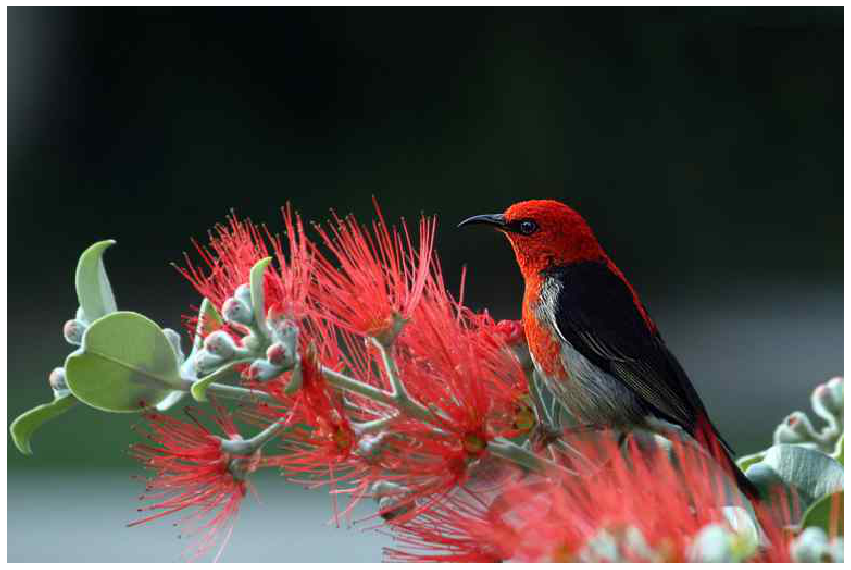

In [12]:
show_image(img, figsize=(15,15), interpolation='nearest');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


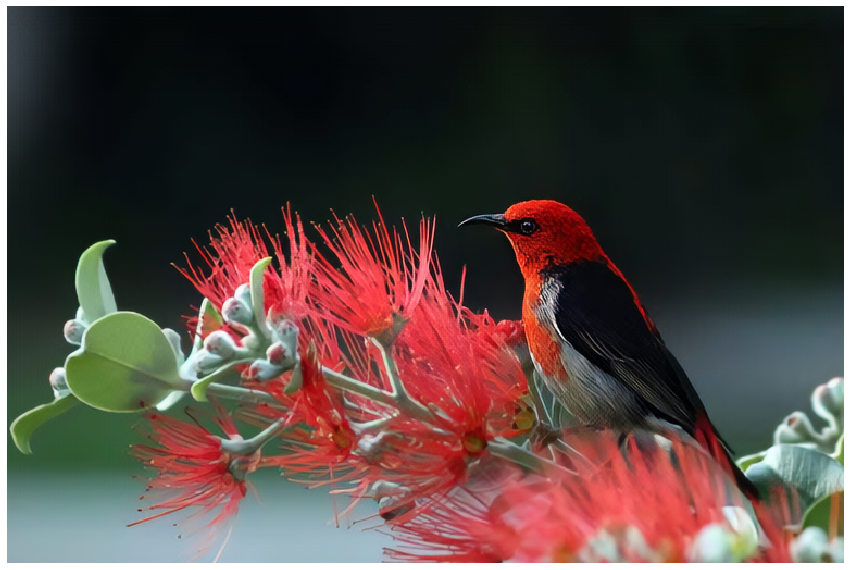

In [15]:
Image(img_hr).show(figsize=(15,15))